In [2]:
%matplotlib inline
import axs
import os

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from astropy.io import ascii

import pyspark.sql.functions as sparkfunc

In [3]:
matplotlib.rcParams['figure.dpi'] = 120

In [4]:
def spark_start(project_path, metastore=None, local_dir=None):
    from pyspark.sql import SparkSession

    warehouse_location = project_path #os.path.join(project_path, 'spark-warehouse')

    if local_dir is None:
        local_dir = os.path.join(project_path, 'spark-tmp')

    spark = ( 
            SparkSession.builder
            .appName("LSD2")
            .config("spark.sql.warehouse.dir", warehouse_location)
            .config('spark.master', "local[6]")
            .config('spark.driver.memory', '8G') # 128
            .config('spark.local.dir', local_dir)
            .config('spark.memory.offHeap.enabled', 'true')
            .config('spark.memory.offHeap.size', '4G') # 256
            .config("spark.sql.execution.arrow.enabled", "true")
            .config("spark.driver.maxResultSize", "6G")
            .config("spark.driver.extraJavaOptions", f"-Dderby.system.home={metastore}")
            .enableHiveSupport()
            .getOrCreate()
                    )   

    return spark

spark_session = spark_start("/epyc/data/", local_dir="/epyc/users/ctslater")

#catalog = axs.AxsCatalog(spark_session)

In [5]:
spark_session

In [6]:
catalog = axs.AxsCatalog(spark_session)

In [9]:
catalog.list_tables().keys()

dict_keys(['sdss_zoned1am_hd', 'gaia_zoned1am_hd', 'gaia_dr2_1am_dup', 'sdss_zoned1am_700lc', 'gaia_dr2_700lc2', 'allwise_1am_dup', 'gaia_sdss_wise_1asec', 'gaia_sdss_3asec', 'ztf_1am_old', 'ztf_exposures', 'ztf_1am_lc', 'ztf_1am', 'ztf_1am_test', 'sesar_rrlyrae', 'ztf_fid1_sdss_stars_lt20_2asec', 'ztf_fid2_sdss_stars_lt20_2asec', 'ztf_fid3_sdss_stars_lt20_2asec', 'sdss_dr9_qso_s82', 'ztf_sdss_dr9_qso', 'faraway_training_dataset', 'faraway_labeled_training_dataset', 'ztf_nobs100', 'jnk_ztf_test', 'jnk_ztf_test2', 'asassn_catalog', 'ztf1000', 'ztf_sdss_dr9_qso2', 'ztf10', 'ztf10_assasn', 'ztf10_assasn_cesium', 'ztf_dec18'])

In [10]:
%%time
ztf = catalog.load("ztf_dec18")

CPU times: user 6.22 ms, sys: 5.11 ms, total: 11.3 ms
Wall time: 8.52 s


In [11]:
ztf

AxsFrame[matchid: bigint, ra: double, dec: double, nobs_avail: bigint, combined_matchids: array<bigint>, mjd: array<double>, programid: array<smallint>, filterid: array<bigint>, mag: array<float>, magerr: array<float>, psfmag: array<float>, psfmagerr: array<float>, psfflux: array<float>, psffluxerr: array<float>, chi: array<float>, catflags: array<smallint>, sharp: array<float>, xpos: array<float>, ypos: array<float>, zone: bigint, dup: int]

In [12]:
%%time
radec = ztf.region(ra1=0, ra2=1, dec1=0, dec2=1).select("ra", "dec").toPandas()

CPU times: user 30.5 ms, sys: 9.45 ms, total: 39.9 ms
Wall time: 12 s


In [13]:
len(radec)

52649

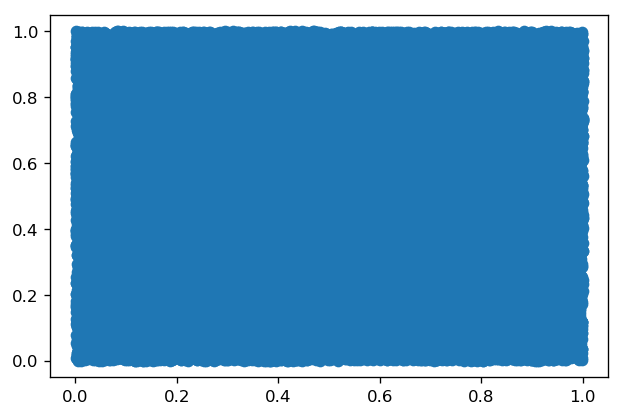

In [14]:
plt.plot(radec['ra'], radec['dec'], 'o')

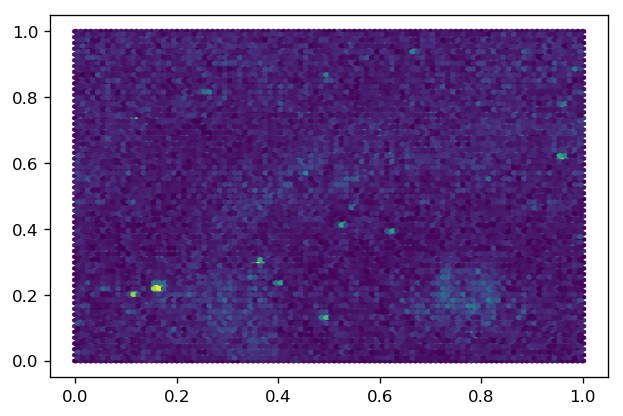

In [15]:
plt.hexbin(radec['ra'], radec['dec'])

In [16]:
sesar_rrlyrae = catalog.load("sesar_rrlyrae")

In [18]:
sesar_rrlyrae.columns

['ra',
 'dec',
 'S3ab',
 'S3c',
 'DM',
 'Per',
 'phi0',
 'gAmp',
 'rAmp',
 'iAmp',
 'zAmp',
 'gmag',
 'rmag',
 'imag',
 'zmag',
 '<gmag>',
 '<rmag>',
 '<imag>',
 '<zmag>',
 'EBV',
 'S10',
 'PS1',
 'Sloan',
 'zone',
 'dup']

In [43]:
%%time
lyrae_match = ztf.crossmatch(sesar_rrlyrae).select("ra", "dec", "mjd", "filterid", "mag", "Per").where("size(mjd) > 30 AND S3ab > 0.8").head(300)

CPU times: user 96.3 ms, sys: 21.4 ms, total: 118 ms
Wall time: 7min 12s


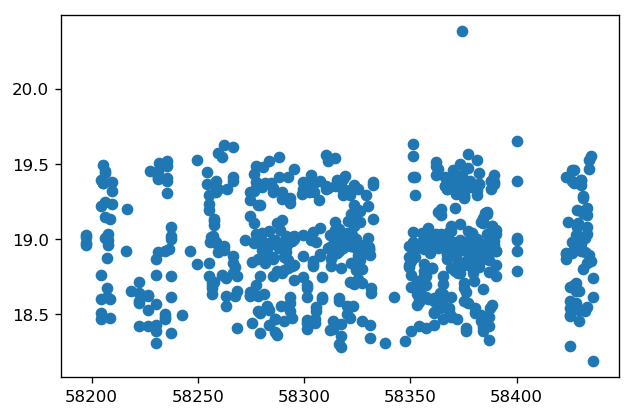

In [35]:
row = lyrae_match[4]
plt.plot(row.mjd, row.mag, 'o')

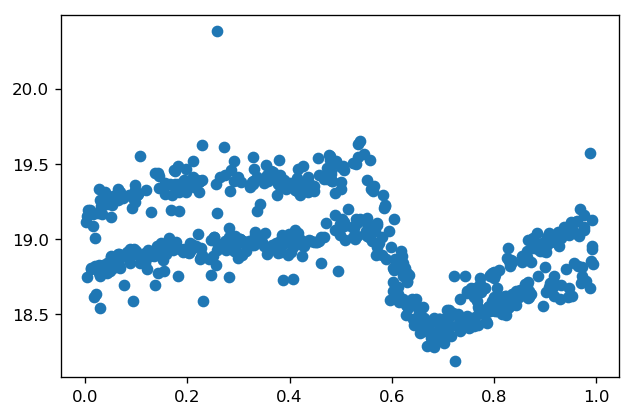

In [36]:
plt.plot(np.array(row.mjd)/row.Per % 1, row.mag, 'o')

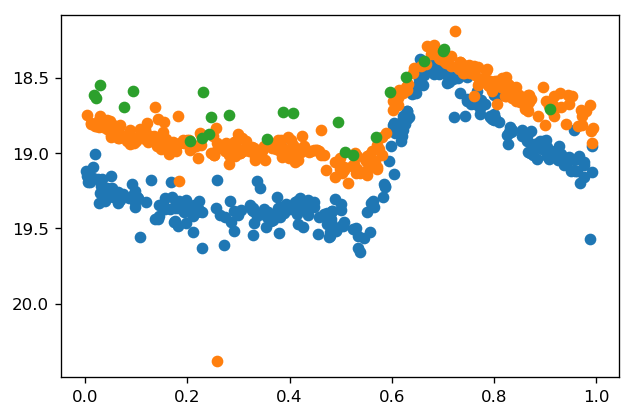

In [38]:
for filterid in [1,2,3]:
    sel, = np.where(np.array(row.filterid) == filterid)
    plt.plot(np.array(row.mjd)[sel]/row.Per % 1, np.array(row.mag)[sel], 'o')
plt.gca().invert_yaxis()